# Automatización en Python del Enfoque sl₂(R) de Turbiner para la Detección de Ecuaciones Diferenciales con Soluciones Polinomiales

Nicolas Moreno Martinez\
Esteban Felipe Tellez Ruiz

## Explicación del metodo

El método de Turbiner se basa en una observación fundamental: cualquier ecuación diferencial que tenga soluciones polinomiales exactas puede construirse usando únicamente tres operadores básicos del álgebra de Lie $sl_2(R)$. Estos operadores actúan sobre espacios de polinomios de manera muy específica.

Los tres generadores fundamentales son:

$J_+ = x^2d_x - nx \quad$ (Operador de "subida" que incrementa el grado del polinomio)\
$J_o = xd_x - \frac{n}{2} \quad$ (Operador "neutro" que mantiene el grado)\
$J_- = d_x \quad$ (Operador de "bajada" que reduce el grado del polinomio)\

Donde n es un entero no negativo que define el espacio de polinomios $P_n = {1, x, x^2, ..., x^n}$.

El concepto clave es la preservación de espacios: un operador diferencial T se llama "cuasi-exactamente resoluble" si transforma cualquier polinomio de grado $\leq$ n en otro polinomio de grado $\leq$ n. Matemáticamente esto significa que T : $P_n \rightarrow P_n$

El teorema principal de Turbiner establece que una ecuación diferencial $T\wp$ = $\lambda \wp$ tiene exactamente (n+1) soluciones polinomiales linealmente independientes si y solo si el operador T puede expresarse como una combinación polinomial de $J_+$, $J_o$ y $J_-$, osea:

T = $\Sigma c_{ijk} (J_+)^i(J_o)^j(J_-)^k$ + términos de orden menor

Esta representación permite clasificar completamente todas las ecuaciones diferenciales con soluciones polinomiales, resolviendo así el problema generalizado de Bochner. El método también se extiende a ecuaciones en diferencias finitas usando versiones cuánticas deformadas de estos operadores.

Turbiner, A. (1992). Lie-algebraic approach to the theory of polynomial solutions. I. Ordinary differential equations and finite-difference equations in one variable. arXiv preprint hep-th/9209079.

## Metodo automatizado

In [3]:
# Importamos las librerias
from sympy import symbols, diff, simplify, lambdify
import numpy as np
import matplotlib.pyplot as plt

# Símbolos globales
x = symbols('x')

In [5]:
def J_plus(poly, n):
    """J_+ = x²∂_x - nx  (sube grado)"""
    return x**2 * diff(poly, x) - n*x*poly

def J_zero(poly, n):
    """J_0 = x∂_x - n/2  (mantiene grado)"""
    return x * diff(poly, x) - (n/2)*poly

def J_minus(poly):
    """J_- = ∂_x  (baja grado)"""
    return diff(poly, x)

In [7]:
def resolver(operador, n):
    """
    Resuelve T·φ = λ·φ
    
    operador: dict {(a,b,c): coef} donde (a,b,c) = J₊^a·J₀^b·J₋^c
    n: grado máximo
    
    Retorna: lista de (polinomio, eigenvalor)
    """
    # Construir operador
    def T(poly):
        resultado = 0
        for (a, b, c), coef in operador.items():
            temp = poly
            for _ in range(a):
                temp = J_plus(temp, n)
            for _ in range(b):
                temp = J_zero(temp, n)
            for _ in range(c):
                temp = J_minus(temp)
            resultado += coef * temp
        return simplify(resultado)
    
    # Construir matriz
    base = [x**i for i in range(n + 1)]
    M = []
    
    for i in range(n + 1):
        fila = []
        for j in range(n + 1):
            res = T(base[j])
            coef = res.coeff(x, i) if res != 0 else 0
            try:
                fila.append(float(coef.evalf()) if coef != 0 else 0.0)
            except:
                fila.append(0.0)
        M.append(fila)
    
    # Resolver
    M = np.array(M)
    vals, vecs = np.linalg.eig(M)
    
    soluciones = []
    for i in range(len(vals)):
        coefs = vecs[:, i].real
        
        # Limpiar coeficientes pequeños
        coefs[np.abs(coefs) < 1e-10] = 0
        
        # Hacer el coeficiente principal = 1
        idx_max = np.argmax(np.abs(coefs))
        if coefs[idx_max] != 0:
            coefs = coefs / coefs[idx_max]
        
        # Construir polinomio
        poly = sum(coefs[j] * x**j for j in range(n + 1))
        poly = simplify(poly)
        
        if poly != 0:
            soluciones.append((poly, vals[i].real))
    
    # Ordenar por eigenvalor
    soluciones.sort(key=lambda s: s[1])
    return soluciones

In [9]:
def graficar(soluciones, titulo="Soluciones"):
    """Grafica las soluciones"""
    
    plt.figure(figsize=(12, 6))
    x_vals = np.linspace(-3, 3, 500)
    
    for i, (poly, eigen) in enumerate(soluciones):
        # Evaluar polinomio
        f = lambdify(x, poly, 'numpy')
        y_vals = f(x_vals)
        
        if np.isscalar(y_vals):
            y_vals = np.full_like(x_vals, y_vals)
        
        # Graficar directo (SIN normalizar)
        plt.plot(x_vals, y_vals, label=f'φ_{i}(x), λ={eigen:.2f}', linewidth=2)
    
    plt.xlabel('x', fontsize=14)
    plt.ylabel('φ(x)', fontsize=14)
    plt.title(titulo, fontsize=16, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.4)
    plt.axhline(0, color='black', linewidth=0.8)
    plt.axvline(0, color='black', linewidth=0.8)
    plt.tight_layout()
    plt.show()
    
    # Imprimir polinomios
    print("\n" + "="*70)
    print(f"  {titulo}")
    print("="*70)
    for i, (poly, eigen) in enumerate(soluciones):
        print(f"\nφ_{i}(x) = {poly}")
        print(f"λ_{i} = {eigen:.4f}")
    print()


## Ejemplo de uso

Operador de Euler


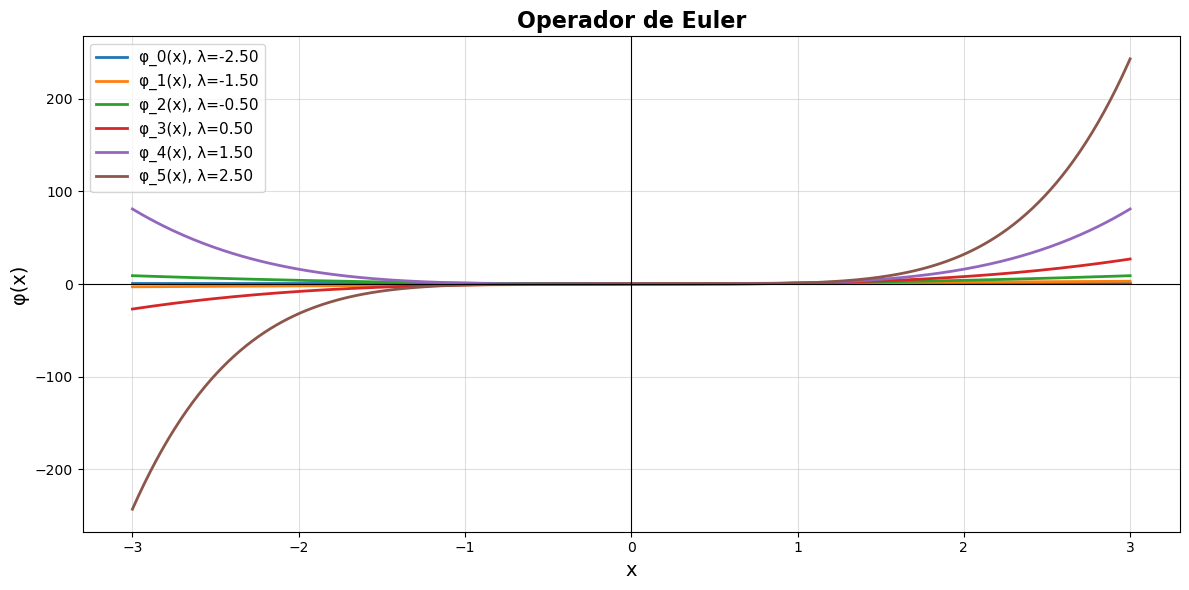


  Operador de Euler

φ_0(x) = 1.00000000000000
λ_0 = -2.5000

φ_1(x) = 1.0*x
λ_1 = -1.5000

φ_2(x) = 1.0*x**2
λ_2 = -0.5000

φ_3(x) = 1.0*x**3
λ_3 = 0.5000

φ_4(x) = 1.0*x**4
λ_4 = 1.5000

φ_5(x) = 1.0*x**5
λ_5 = 2.5000


Cada polinomio xⁿ tiene eigenvalor n - n/2


In [21]:
print("Operador de Euler")

operador = {(0,1,0): 1} # Solo j0
sols_euler = resolver(operador, n=5)
graficar(sols_euler, "Operador de Euler")

print("\nCada polinomio xⁿ tiene eigenvalor n - n/2")

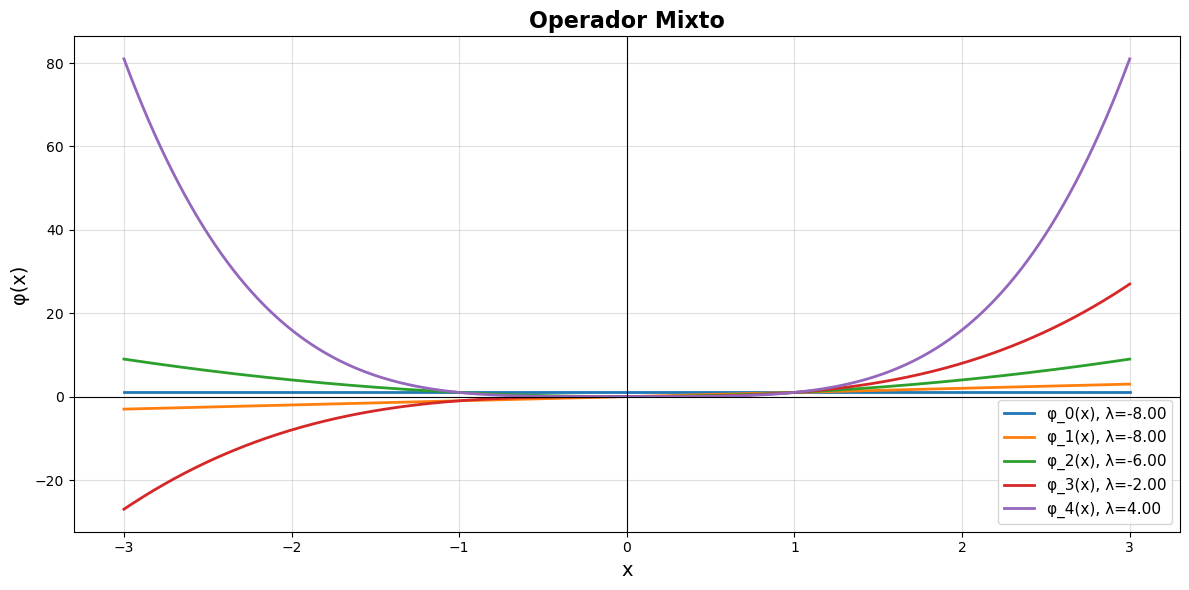


  Operador Mixto

φ_0(x) = 1.00000000000000
λ_0 = -8.0000

φ_1(x) = 1.0*x
λ_1 = -8.0000

φ_2(x) = 1.0*x**2
λ_2 = -6.0000

φ_3(x) = 1.0*x**3
λ_3 = -2.0000

φ_4(x) = 1.0*x**4
λ_4 = 4.0000



In [23]:
# Operador: T = J₊ · J₋ + 2J₀
operador_mixto = {
    (1,0,1): 1,   # J₊·J₋
    (0,1,0): 2    # 2J₀
}
sols = resolver(operador_mixto, n=4)
graficar(sols, "Operador Mixto")